# Debug Forecast Data Loading Pipeline

This notebook walks through each step of `_load_forecast_xarray_data()` to diagnose issues with the NOAA GEFS data loading.

## Setup

In [1]:
import os
import sys
from pathlib import Path

# Set working directory
os.chdir('/home/sngrj0hn/GitHub/neuralhydrology')
print(f"Working directory: {os.getcwd()}")

Working directory: /home/sngrj0hn/GitHub/neuralhydrology


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralhydrology.utils.config import Config
from neuralhydrology.datautils.fetch_basin_forecasts import (
    load_basin_centroids,
    fetch_forecasts_for_basins,
    interpolate_to_hourly,
)

## Load Configuration

In [3]:
config_path = Path('/home/sngrj0hn/GitHub/neuralhydrology/operational_harz/gefs_10d_sample/config.yml')
config = Config(config_path)

print("Forecast inputs from config:")
print(config.forecast_inputs)

# Load basins from basins.txt file
basins_file = Path('/home/sngrj0hn/GitHub/neuralhydrology/operational_harz/gefs_10d_sample/basins.txt')
with open(basins_file, 'r') as f:
    basins = [line.strip() for line in f if line.strip()]

print(f"\nBasins (from {basins_file.name}):")
print(basins)

Forecast inputs from config:
['maximum_temperature_2m_q25', 'maximum_temperature_2m_q50', 'maximum_temperature_2m_q75', 'minimum_temperature_2m_q25', 'minimum_temperature_2m_q50', 'minimum_temperature_2m_q75', 'precipitation_surface_q25', 'precipitation_surface_q50', 'precipitation_surface_q75', 'relative_humidity_2m_q25', 'relative_humidity_2m_q50', 'relative_humidity_2m_q75', 'temperature_2m_q25', 'temperature_2m_q50', 'temperature_2m_q75']

Basins (from basins.txt):
['DE1', 'DE2', 'DE3', 'DE4', 'DE5']


## Step 1: Load Basin Centroids

In [4]:
basin_centroids_file = config.data_dir / "basin_centroids" / "basin_centroids.csv"
print(f"Looking for centroids at: {basin_centroids_file}")
print(f"File exists: {basin_centroids_file.exists()}")

centroids = load_basin_centroids(basin_centroids_file)
print(f"\nLoaded {len(centroids)} centroids")
centroids.head()

Looking for centroids at: data/harz/basin_centroids/basin_centroids.csv
File exists: True

Loaded 5 centroids


,basin_name,latitude,longitude
0,DE1,51.834451,10.307828
1,DE2,51.816468,10.447276
2,DE3,51.810056,10.584058
3,DE4,51.752310,10.383225
4,DE5,51.884391,10.357203


In [5]:
# Filter to config basins
centroids_filtered = centroids[centroids['basin_name'].isin(basins)]
print(f"Filtered to {len(centroids_filtered)} basins matching basins.txt")
centroids_filtered

Filtered to 5 basins matching basins.txt


,basin_name,latitude,longitude
0,DE1,51.834451,10.307828
1,DE2,51.816468,10.447276
2,DE3,51.810056,10.584058
3,DE4,51.752310,10.383225
4,DE5,51.884391,10.357203


## Step 2: Connect to NOAA GEFS Dataset

In [6]:
print("Connecting to NOAA GEFS Zarr store...")
ds = xr.open_zarr(
    "https://data.dynamical.org/noaa/gefs/forecast-35-day/latest.zarr?email=optional@email.com", 
    decode_timedelta=True
)

print("\nDataset dimensions:")
print(ds.dims)
print("\nAvailable variables (first 20):")
print(list(ds.data_vars)[:20])

Connecting to NOAA GEFS Zarr store...

Dataset dimensions:
FrozenMappingWarningOnValuesAccess({'init_time': 1854, 'ensemble_member': 31, 'lead_time': 181, 'latitude': 721, 'longitude': 1440})

Available variables (first 20):
['categorical_freezing_rain_surface', 'categorical_ice_pellets_surface', 'categorical_rain_surface', 'categorical_snow_surface', 'downward_long_wave_radiation_flux_surface', 'downward_short_wave_radiation_flux_surface', 'geopotential_height_cloud_ceiling', 'maximum_temperature_2m', 'minimum_temperature_2m', 'percent_frozen_precipitation_surface', 'precipitable_water_atmosphere', 'precipitation_surface', 'pressure_reduced_to_mean_sea_level', 'pressure_surface', 'relative_humidity_2m', 'temperature_2m', 'total_cloud_cover_atmosphere', 'wind_u_100m', 'wind_u_10m', 'wind_v_100m']

Dataset dimensions:
FrozenMappingWarningOnValuesAccess({'init_time': 1854, 'ensemble_member': 31, 'lead_time': 181, 'latitude': 721, 'longitude': 1440})

Available variables (first 20):
['cat

## Step 3: Extract Base Variables from Config

In [7]:
# Extract base variable names from config (strip quartile suffixes)
base_vars_needed = set()
for var in config.forecast_inputs:
    # Remove quartile suffixes (_q25, _q50, _q75) to get base variable name
    base_var = var.replace('_q25', '').replace('_q50', '').replace('_q75', '')
    base_vars_needed.add(base_var)

print("Config forecast_inputs:")
print(config.forecast_inputs)
print("\nExtracted base variables:")
print(base_vars_needed)

Config forecast_inputs:
['maximum_temperature_2m_q25', 'maximum_temperature_2m_q50', 'maximum_temperature_2m_q75', 'minimum_temperature_2m_q25', 'minimum_temperature_2m_q50', 'minimum_temperature_2m_q75', 'precipitation_surface_q25', 'precipitation_surface_q50', 'precipitation_surface_q75', 'relative_humidity_2m_q25', 'relative_humidity_2m_q50', 'relative_humidity_2m_q75', 'temperature_2m_q25', 'temperature_2m_q50', 'temperature_2m_q75']

Extracted base variables:
{'precipitation_surface', 'relative_humidity_2m', 'maximum_temperature_2m', 'temperature_2m', 'minimum_temperature_2m'}


In [8]:
# Check which base variables are available
available_base_vars = [v for v in base_vars_needed if v in ds.data_vars]
missing_base_vars = [v for v in base_vars_needed if v not in ds.data_vars]

print(f"Available base variables: {available_base_vars}")
print(f"Missing base variables: {missing_base_vars}")

if missing_base_vars:
    print("\n⚠️ WARNING: Some base variables are missing!")
    print("\nSuggested alternatives in dataset:")
    for missing in missing_base_vars:
        matches = [v for v in ds.data_vars if missing.lower() in v.lower()]
        if matches:
            print(f"  {missing} → {matches[:5]}")

Available base variables: ['precipitation_surface', 'relative_humidity_2m', 'maximum_temperature_2m', 'temperature_2m', 'minimum_temperature_2m']
Missing base variables: []


## Step 4: Filter Dataset to Needed Variables

In [9]:
if not available_base_vars:
    raise ValueError(f"None of the base variables {base_vars_needed} found in NOAA dataset")

print(f"Filtering dataset to: {available_base_vars}")
ds_filtered = ds[available_base_vars]

print("\nFiltered dataset:")
print(ds_filtered)

Filtering dataset to: ['precipitation_surface', 'relative_humidity_2m', 'maximum_temperature_2m', 'temperature_2m', 'minimum_temperature_2m']

Filtered dataset:
<xarray.Dataset> Size: 216TB
Dimensions:                   (init_time: 1854, ensemble_member: 31,
                               lead_time: 181, latitude: 721, longitude: 1440)
Coordinates:
  * ensemble_member           (ensemble_member) int16 62B 0 1 2 3 ... 28 29 30
    expected_forecast_length  (init_time) timedelta64[ns] 15kB dask.array<chunksize=(1854,), meta=np.ndarray>
    ingested_forecast_length  (init_time, ensemble_member) timedelta64[ns] 460kB dask.array<chunksize=(1854, 31), meta=np.ndarray>
  * init_time                 (init_time) datetime64[ns] 15kB 2020-10-01 ... ...
  * latitude                  (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * lead_time                 (lead_time) timedelta64[ns] 1kB 00:00:00 ... 35...
  * longitude                 (longitude) float64 12kB -180.0 -179.8 ... 179.8
    spa

## Step 5: Extract Forecasts for Basin Centroids

In [10]:
print("Extracting forecasts for basin centroids...")
print("This may take a few minutes...\n")

basin_forecasts = fetch_forecasts_for_basins(ds_filtered, centroids_filtered)

print("Basin forecasts extracted:")
print(basin_forecasts)

Extracting forecasts for basin centroids...
This may take a few minutes...

Basin forecasts extracted:
<xarray.Dataset> Size: 1GB
Dimensions:                   (basin: 5, init_time: 1854, ensemble_member: 31,
                               lead_time: 181)
Coordinates:
  * ensemble_member           (ensemble_member) int16 62B 0 1 2 3 ... 28 29 30
    expected_forecast_length  (init_time) timedelta64[ns] 15kB dask.array<chunksize=(1854,), meta=np.ndarray>
    ingested_forecast_length  (init_time, ensemble_member) timedelta64[ns] 460kB dask.array<chunksize=(1854, 31), meta=np.ndarray>
  * init_time                 (init_time) datetime64[ns] 15kB 2020-10-01 ... ...
    latitude                  (basin) float64 40B 51.75 51.75 51.75 51.75 52.0
  * lead_time                 (lead_time) timedelta64[ns] 1kB 00:00:00 ... 35...
    longitude                 (basin) float64 40B 10.25 10.5 10.5 10.5 10.25
    spatial_ref               int64 8B ...
    valid_time                (init_time, lead_tim

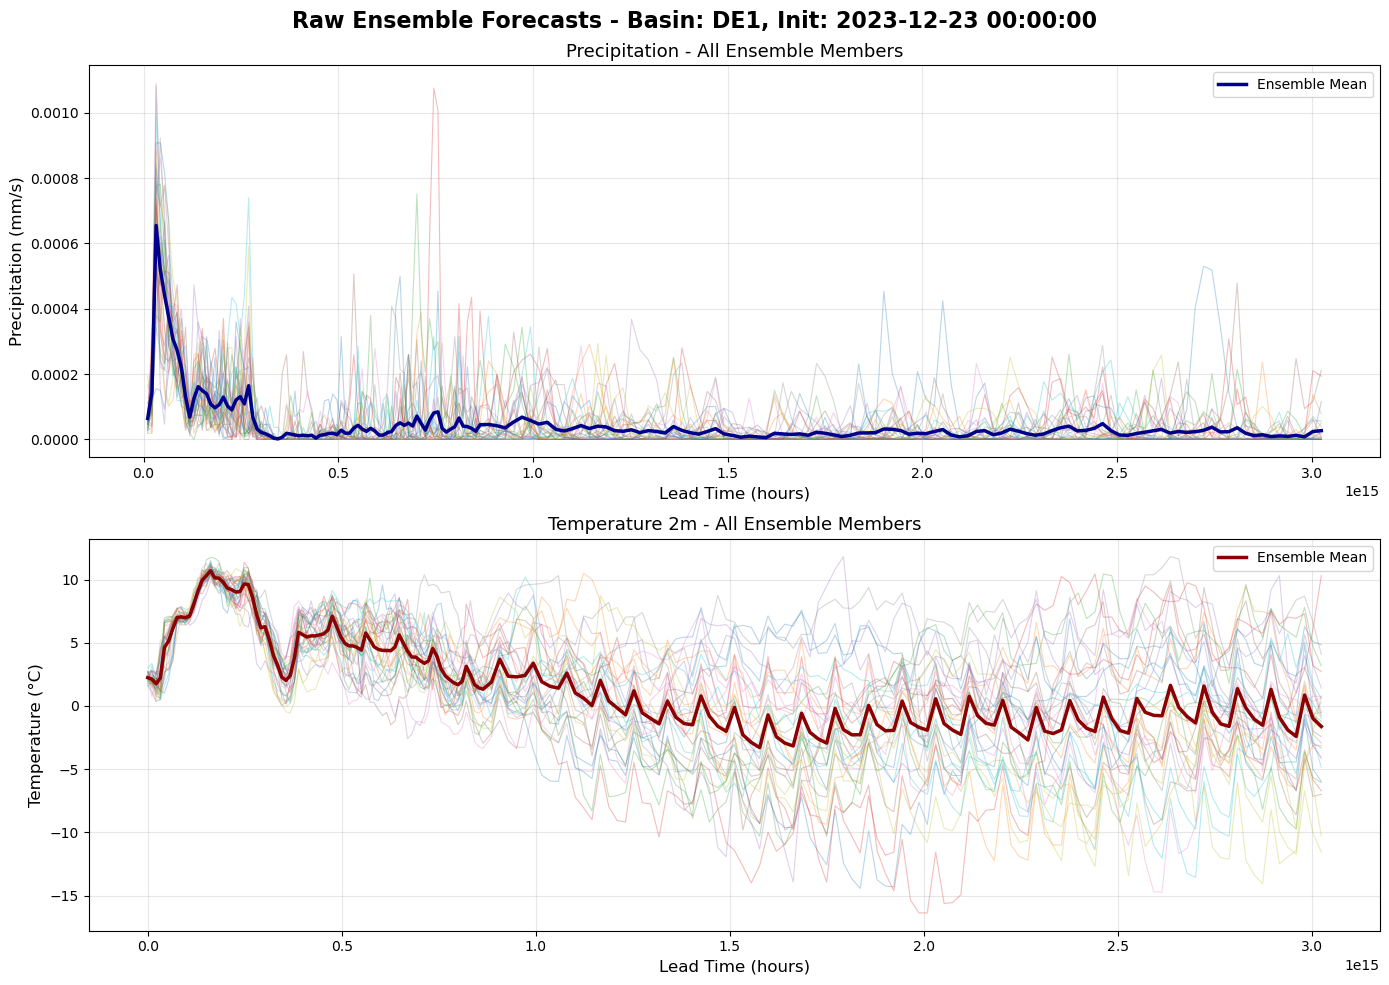


Plotted 31 ensemble members for basin DE1
Init time: 2023-12-23 00:00:00


In [13]:
# Select first basin and specific init time for visualization
basin_idx = 0
basin_name = centroids_filtered.iloc[basin_idx]['basin_name']
init_time = pd.Timestamp('2023-12-23 00:00')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle(f'Raw Ensemble Forecasts - Basin: {basin_name}, Init: {init_time}', fontsize=16, fontweight='bold')

# Plot 1: Precipitation - All ensemble members
if 'precipitation_surface' in basin_forecasts.data_vars:
    precip_data = basin_forecasts['precipitation_surface'].sel(basin=basin_name, init_time=init_time)
    precip_data.plot(x='lead_time', hue='ensemble_member', ax=axes[0], alpha=0.3, linewidth=0.8, add_legend=False)
    
    # Add ensemble mean
    precip_data.mean(dim='ensemble_member').plot(x='lead_time', ax=axes[0], color='darkblue', linewidth=2.5, label='Ensemble Mean')
    
    axes[0].set_ylabel('Precipitation (mm/s)', fontsize=12)
    axes[0].set_xlabel('Lead Time (hours)', fontsize=12)
    axes[0].set_title('Precipitation - All Ensemble Members', fontsize=13)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

# Plot 2: Temperature - All ensemble members
if 'temperature_2m' in basin_forecasts.data_vars:
    temp_data = basin_forecasts['temperature_2m'].sel(basin=basin_name, init_time=init_time)
    temp_data.plot(x='lead_time', hue='ensemble_member', ax=axes[1], alpha=0.3, linewidth=0.8, add_legend=False)
    
    # Add ensemble mean
    temp_data.mean(dim='ensemble_member').plot(x='lead_time', ax=axes[1], color='darkred', linewidth=2.5, label='Ensemble Mean')
    
    axes[1].set_ylabel('Temperature (°C)', fontsize=12)
    axes[1].set_xlabel('Lead Time (hours)', fontsize=12)
    axes[1].set_title('Temperature 2m - All Ensemble Members', fontsize=13)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPlotted {precip_data.sizes['ensemble_member']} ensemble members for basin {basin_name}")
print(f"Init time: {init_time}")


## Step 6: Compute Quartiles

In [14]:
print("Computing quartiles...")

quartiles = (0.25, 0.5, 0.75)
quartile_suffixes = {0.25: '_q25', 0.5: '_q50', 0.75: '_q75'}

new_data_vars = {}

for var_name in basin_forecasts.data_vars:
    var_data = basin_forecasts[var_name]
    var_quartiles = var_data.quantile(quartiles, dim='ensemble_member')
    
    for i, q in enumerate(quartiles):
        suffix = quartile_suffixes.get(q, f'_q{int(q*100)}')
        new_var_name = f"{var_name}{suffix}"
        quartile_data = var_quartiles.isel(quantile=i).drop('quantile')
        new_data_vars[new_var_name] = quartile_data

coords_to_keep = {k: v for k, v in basin_forecasts.coords.items() if 'ensemble_member' not in v.dims}
basin_forecasts_quartiles = xr.Dataset(data_vars=new_data_vars, coords=coords_to_keep)

print("Quartile variables created:")
print(list(basin_forecasts_quartiles.data_vars))

Computing quartiles...
Quartile variables created:
['precipitation_surface_q25', 'precipitation_surface_q50', 'precipitation_surface_q75', 'relative_humidity_2m_q25', 'relative_humidity_2m_q50', 'relative_humidity_2m_q75', 'maximum_temperature_2m_q25', 'maximum_temperature_2m_q50', 'maximum_temperature_2m_q75', 'temperature_2m_q25', 'temperature_2m_q50', 'temperature_2m_q75', 'minimum_temperature_2m_q25', 'minimum_temperature_2m_q50', 'minimum_temperature_2m_q75']
Quartile variables created:
['precipitation_surface_q25', 'precipitation_surface_q50', 'precipitation_surface_q75', 'relative_humidity_2m_q25', 'relative_humidity_2m_q50', 'relative_humidity_2m_q75', 'maximum_temperature_2m_q25', 'maximum_temperature_2m_q50', 'maximum_temperature_2m_q75', 'temperature_2m_q25', 'temperature_2m_q50', 'temperature_2m_q75', 'minimum_temperature_2m_q25', 'minimum_temperature_2m_q50', 'minimum_temperature_2m_q75']


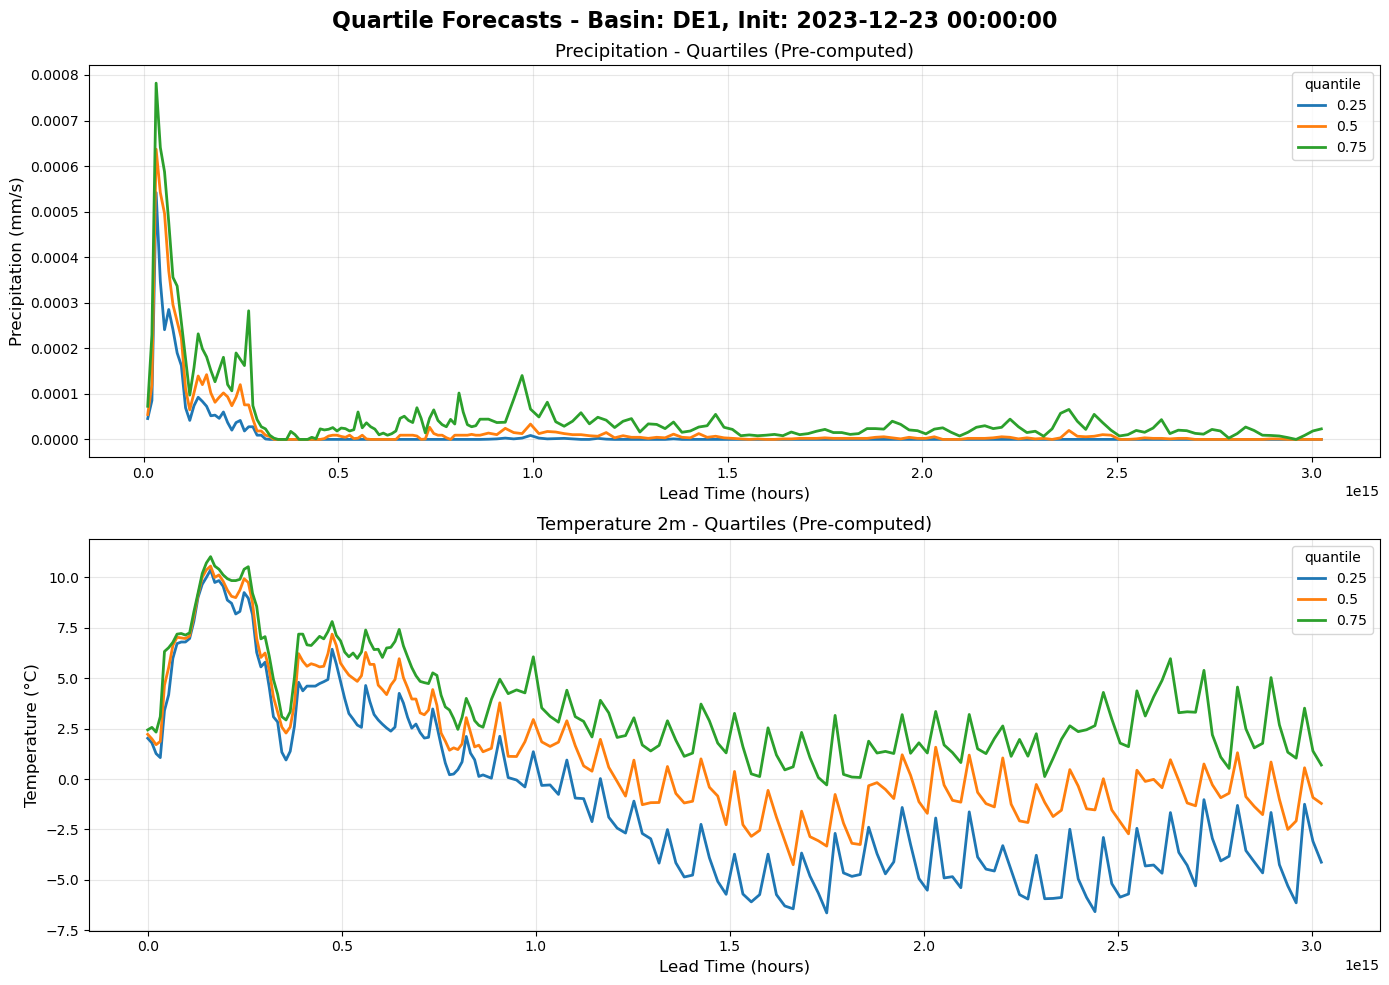


Quartile ranges show forecast uncertainty for basin DE1
Init time: 2023-12-23 00:00:00
(Using pre-computed quartile variables - no recomputation!)


In [15]:
# Select first basin and specific init time for visualization
basin_idx = 0
basin_name = centroids_filtered.iloc[basin_idx]['basin_name']
init_time = pd.Timestamp('2023-12-23 00:00')

fig, axes = plt.subplots(2, 1, figsize=(14, 10))
fig.suptitle(f'Quartile Forecasts - Basin: {basin_name}, Init: {init_time}', fontsize=16, fontweight='bold')

# Plot 1: Precipitation Quartiles - Using pre-computed quartile variables
if 'precipitation_surface_q50' in basin_forecasts_quartiles.data_vars:
    precip_quartiles = xr.concat([
        basin_forecasts_quartiles['precipitation_surface_q25'],
        basin_forecasts_quartiles['precipitation_surface_q50'],
        basin_forecasts_quartiles['precipitation_surface_q75']
    ], dim=pd.Index([0.25, 0.5, 0.75], name='quantile'))
    
    precip_quartiles.sel(basin=basin_name, init_time=init_time).plot(
        x='lead_time', 
        hue='quantile', 
        ax=axes[0],
        linewidth=2
    )
    axes[0].set_ylabel('Precipitation (mm/s)', fontsize=12)
    axes[0].set_xlabel('Lead Time (hours)', fontsize=12)
    axes[0].set_title('Precipitation - Quartiles (Pre-computed)', fontsize=13)
    axes[0].grid(True, alpha=0.3)

# Plot 2: Temperature Quartiles - Using pre-computed quartile variables
if 'temperature_2m_q50' in basin_forecasts_quartiles.data_vars:
    temp_quartiles = xr.concat([
        basin_forecasts_quartiles['temperature_2m_q25'],
        basin_forecasts_quartiles['temperature_2m_q50'],
        basin_forecasts_quartiles['temperature_2m_q75']
    ], dim=pd.Index([0.25, 0.5, 0.75], name='quantile'))
    
    temp_quartiles.sel(basin=basin_name, init_time=init_time).plot(
        x='lead_time', 
        hue='quantile', 
        ax=axes[1],
        linewidth=2
    )
    axes[1].set_ylabel('Temperature (°C)', fontsize=12)
    axes[1].set_xlabel('Lead Time (hours)', fontsize=12)
    axes[1].set_title('Temperature 2m - Quartiles (Pre-computed)', fontsize=13)
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nQuartile ranges show forecast uncertainty for basin {basin_name}")
print(f"Init time: {init_time}")
print("(Using pre-computed quartile variables - no recomputation!)")


## Step 7: Interpolate to Hourly

In [16]:
print("Interpolating to hourly resolution (first 240 hours)...")
basin_forecasts_hourly = interpolate_to_hourly(basin_forecasts_quartiles, max_hours=240)

print("\nHourly forecast dataset:")
print(basin_forecasts_hourly)
print(f"\nLead time range: {basin_forecasts_hourly.lead_time.min().values} to {basin_forecasts_hourly.lead_time.max().values}")

Interpolating to hourly resolution (first 240 hours)...

Hourly forecast dataset:
<xarray.Dataset> Size: 267MB
Dimensions:                     (init_time: 1854, basin: 5, lead_time: 240)
Coordinates:
    expected_forecast_length    (init_time) timedelta64[ns] 15kB dask.array<chunksize=(1854,), meta=np.ndarray>
  * init_time                   (init_time) datetime64[ns] 15kB 2020-10-01 .....
    latitude                    (basin) float64 40B 51.75 51.75 51.75 51.75 52.0
    longitude                   (basin) float64 40B 10.25 10.5 10.5 10.5 10.25
  * basin                       (basin) <U3 60B 'DE1' 'DE2' 'DE3' 'DE4' 'DE5'
    spatial_ref                 int64 8B ...
  * lead_time                   (lead_time) int64 2kB 1 2 3 4 ... 238 239 240
Data variables: (12/15)
    precipitation_surface_q25   (basin, init_time, lead_time) float64 18MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    precipitation_surface_q50   (basin, init_time, lead_time) float64 18MB dask.array<chunksize=

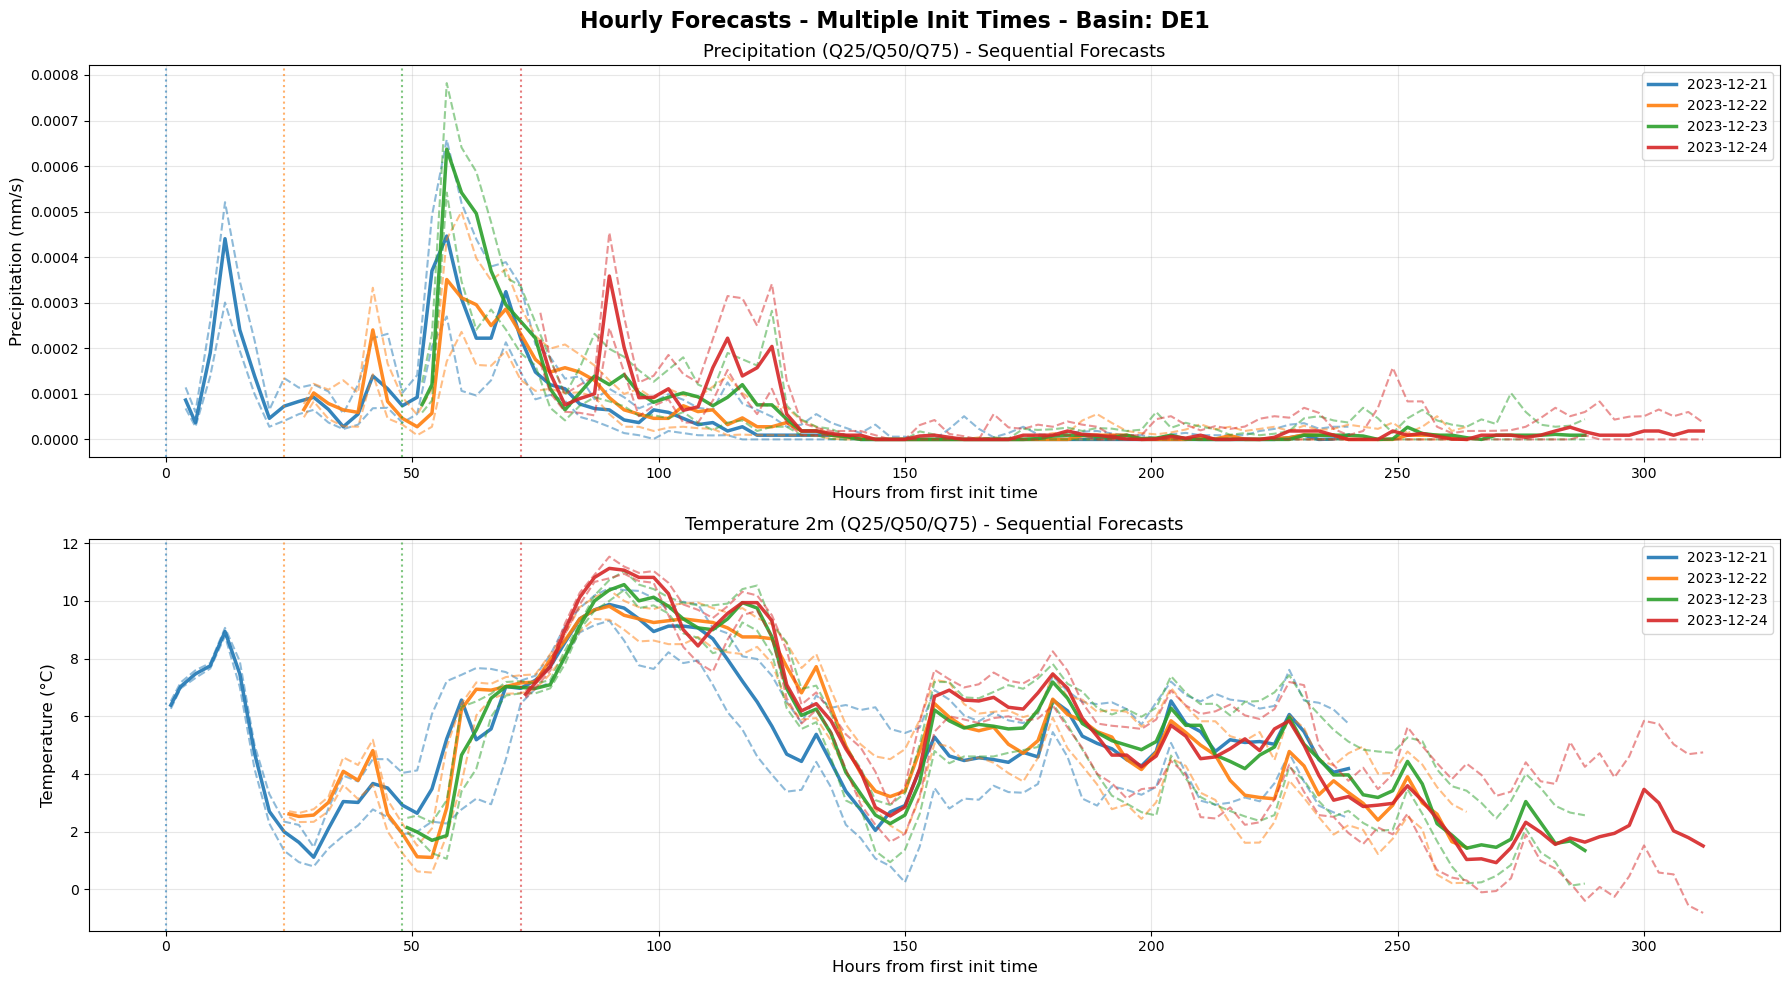


Plotted sequential forecasts for basin DE1
Init times: ['2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24']
Each forecast starts 24 hours after the previous one (marked by vertical dotted lines)
Solid lines: Q50 (median), Dashed lines: Q25/Q75 (uncertainty bounds)
Total time span: ~336 hours


In [22]:
# Select first basin and multiple init times for visualization
basin_idx = 0
basin_name = centroids_filtered.iloc[basin_idx]['basin_name']

# Define multiple init times to plot
init_times = [
    pd.Timestamp('2023-12-21 00:00'),
    pd.Timestamp('2023-12-22 00:00'),
    pd.Timestamp('2023-12-23 00:00'),
    pd.Timestamp('2023-12-24 00:00')
]

fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle(f'Hourly Forecasts - Multiple Init Times - Basin: {basin_name}', fontsize=16, fontweight='bold')

# Define base colors from matplotlib's tableau palette
base_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

# Plot 1: Precipitation - Multiple init times with all quartiles
if 'precipitation_surface_q50' in basin_forecasts_hourly.data_vars:
    for i, (init_time, base_color) in enumerate(zip(init_times, base_colors)):
        time_offset_hours = 24 * i
        
        try:
            # Extract all quartiles for this init time using xarray selection
            precip_q25 = basin_forecasts_hourly['precipitation_surface_q25'].sel(basin=basin_name, init_time=init_time)
            precip_q50 = basin_forecasts_hourly['precipitation_surface_q50'].sel(basin=basin_name, init_time=init_time)
            precip_q75 = basin_forecasts_hourly['precipitation_surface_q75'].sel(basin=basin_name, init_time=init_time)
            
            # Get lead_time values - check if they're already numeric or timedelta
            lead_time_vals = precip_q50.lead_time.values
            if np.issubdtype(lead_time_vals.dtype, np.timedelta64):
                lead_time_hours = lead_time_vals / np.timedelta64(1, 'h')
            else:
                lead_time_hours = lead_time_vals.astype(float)
            
            lead_time_shifted = lead_time_hours + time_offset_hours
            
            # Plot using native plotting - Q50 (median) as solid line
            axes[0].plot(lead_time_shifted, precip_q50.values, 
                        color=base_color, linewidth=2.5, label=f'{init_time.date()}', alpha=0.9)
            
            # Plot Q25 and Q75 as dashed lines with same color but more transparent
            axes[0].plot(lead_time_shifted, precip_q25.values, 
                        color=base_color, linewidth=1.5, linestyle='--', alpha=0.5)
            axes[0].plot(lead_time_shifted, precip_q75.values, 
                        color=base_color, linewidth=1.5, linestyle='--', alpha=0.5)
            
            # Mark init time with vertical line
            axes[0].axvline(x=time_offset_hours, color=base_color, linestyle=':', 
                           linewidth=1.5, alpha=0.6)
            
        except KeyError:
            print(f"Warning: Init time {init_time} not found for precipitation")
    
    axes[0].set_ylabel('Precipitation (mm/s)', fontsize=12)
    axes[0].set_xlabel('Hours from first init time', fontsize=12)
    axes[0].set_title('Precipitation (Q25/Q50/Q75) - Sequential Forecasts', fontsize=13)
    axes[0].legend(loc='best')
    axes[0].grid(True, alpha=0.3)

# Plot 2: Temperature - Multiple init times with all quartiles
if 'temperature_2m_q50' in basin_forecasts_hourly.data_vars:
    for i, (init_time, base_color) in enumerate(zip(init_times, base_colors)):
        time_offset_hours = 24 * i
        
        try:
            # Extract all quartiles for this init time using xarray selection
            temp_q25 = basin_forecasts_hourly['temperature_2m_q25'].sel(basin=basin_name, init_time=init_time)
            temp_q50 = basin_forecasts_hourly['temperature_2m_q50'].sel(basin=basin_name, init_time=init_time)
            temp_q75 = basin_forecasts_hourly['temperature_2m_q75'].sel(basin=basin_name, init_time=init_time)
            
            # Get lead_time values - check if they're already numeric or timedelta
            lead_time_vals = temp_q50.lead_time.values
            if np.issubdtype(lead_time_vals.dtype, np.timedelta64):
                lead_time_hours = lead_time_vals / np.timedelta64(1, 'h')
            else:
                lead_time_hours = lead_time_vals.astype(float)
            
            lead_time_shifted = lead_time_hours + time_offset_hours
            
            # Plot using native plotting - Q50 (median) as solid line
            axes[1].plot(lead_time_shifted, temp_q50.values, 
                        color=base_color, linewidth=2.5, label=f'{init_time.date()}', alpha=0.9)
            
            # Plot Q25 and Q75 as dashed lines with same color but more transparent
            axes[1].plot(lead_time_shifted, temp_q25.values, 
                        color=base_color, linewidth=1.5, linestyle='--', alpha=0.5)
            axes[1].plot(lead_time_shifted, temp_q75.values, 
                        color=base_color, linewidth=1.5, linestyle='--', alpha=0.5)
            
            # Mark init time with vertical line
            axes[1].axvline(x=time_offset_hours, color=base_color, linestyle=':', 
                           linewidth=1.5, alpha=0.6)
            
        except KeyError:
            print(f"Warning: Init time {init_time} not found for temperature")
    
    axes[1].set_ylabel('Temperature (°C)', fontsize=12)
    axes[1].set_xlabel('Hours from first init time', fontsize=12)
    axes[1].set_title('Temperature 2m (Q25/Q50/Q75) - Sequential Forecasts', fontsize=13)
    axes[1].legend(loc='best')
    axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPlotted sequential forecasts for basin {basin_name}")
print(f"Init times: {[str(t.date()) for t in init_times]}")
print(f"Each forecast starts 24 hours after the previous one (marked by vertical dotted lines)")
print(f"Solid lines: Q50 (median), Dashed lines: Q25/Q75 (uncertainty bounds)")
print(f"Total time span: ~{len(init_times) * 24 + 240} hours")


## Step 8: Final Variable Filtering

In [23]:
# Check which config variables are available after processing
forecast_vars = [var for var in basin_forecasts_hourly.data_vars if var in config.forecast_inputs]
missing_vars = [var for var in config.forecast_inputs if var not in basin_forecasts_hourly.data_vars]

print(f"Config requested: {len(config.forecast_inputs)} variables")
print(f"Available after processing: {len(forecast_vars)} variables")
print(f"Missing: {len(missing_vars)} variables")

if missing_vars:
    print(f"\n⚠️ Missing variables: {missing_vars}")

if forecast_vars:
    basin_forecasts_final = basin_forecasts_hourly[forecast_vars]
    print("\nFinal filtered dataset:")
    print(basin_forecasts_final)
else:
    print("\n❌ ERROR: No matching variables found!")

Config requested: 15 variables
Available after processing: 15 variables
Missing: 0 variables

Final filtered dataset:
<xarray.Dataset> Size: 267MB
Dimensions:                     (basin: 5, init_time: 1854, lead_time: 240)
Coordinates:
    expected_forecast_length    (init_time) timedelta64[ns] 15kB dask.array<chunksize=(1854,), meta=np.ndarray>
  * init_time                   (init_time) datetime64[ns] 15kB 2020-10-01 .....
    latitude                    (basin) float64 40B 51.75 51.75 51.75 51.75 52.0
    longitude                   (basin) float64 40B 10.25 10.5 10.5 10.5 10.25
  * basin                       (basin) <U3 60B 'DE1' 'DE2' 'DE3' 'DE4' 'DE5'
    spatial_ref                 int64 8B ...
  * lead_time                   (lead_time) int64 2kB 1 2 3 4 ... 238 239 240
Data variables: (12/15)
    precipitation_surface_q25   (basin, init_time, lead_time) float64 18MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    precipitation_surface_q50   (basin, init_time, lead_time

## Step 9: Compute (Materialize Dask Arrays)

In [24]:
print("Dataset before compute (Dask-backed):")
print(basin_forecasts_final)
print(f"\nMemory usage: {basin_forecasts_final.nbytes / 1e9:.2f} GB")

Dataset before compute (Dask-backed):
<xarray.Dataset> Size: 267MB
Dimensions:                     (basin: 5, init_time: 1854, lead_time: 240)
Coordinates:
    expected_forecast_length    (init_time) timedelta64[ns] 15kB dask.array<chunksize=(1854,), meta=np.ndarray>
  * init_time                   (init_time) datetime64[ns] 15kB 2020-10-01 .....
    latitude                    (basin) float64 40B 51.75 51.75 51.75 51.75 52.0
    longitude                   (basin) float64 40B 10.25 10.5 10.5 10.5 10.25
  * basin                       (basin) <U3 60B 'DE1' 'DE2' 'DE3' 'DE4' 'DE5'
    spatial_ref                 int64 8B ...
  * lead_time                   (lead_time) int64 2kB 1 2 3 4 ... 238 239 240
Data variables: (12/15)
    precipitation_surface_q25   (basin, init_time, lead_time) float64 18MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    precipitation_surface_q50   (basin, init_time, lead_time) float64 18MB dask.array<chunksize=(1, 1, 240), meta=np.ndarray>
    precipitat

## Summary & Diagnostics

In [ ]:
print("=" * 60)
print("PIPELINE SUMMARY")
print("=" * 60)
print(f"\n1. Basins loaded: {len(centroids_filtered)}")
print(f"2. Base variables requested: {len(base_vars_needed)}")
print(f"3. Base variables available: {len(available_base_vars)}")
print(f"4. Quartile variables created: {len(basin_forecasts_quartiles.data_vars)}")
print(f"5. Config variables matched: {len(forecast_vars)}/{len(config.forecast_inputs)}")
print(f"6. Final dataset size: {basin_forecasts_final.nbytes / 1e9:.2f} GB")
print(f"7. Time dimension: {len(basin_forecasts_final.time)} steps")
print(f"8. Lead time dimension: {len(basin_forecasts_final.lead_time)} hours")

if missing_vars:
    print(f"\n⚠️ WARNINGS:")
    print(f"   - {len(missing_vars)} configured variables are missing")
    print(f"   - Check config.yml forecast_inputs")
else:
    print(f"\n✅ All configured variables successfully loaded")